In [40]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os
import pickle
from utils.functions import sample, get_error_term
from model.vae_model import vae_model

In [41]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

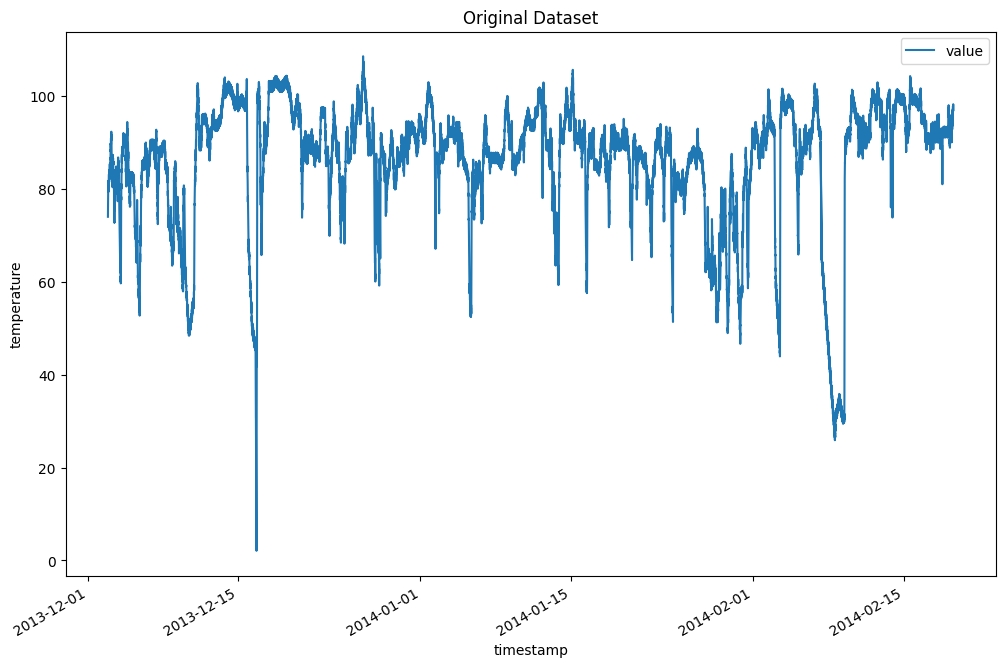

In [42]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [43]:
data['label'] = 1
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances= lists[0]


In [44]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 0

In [45]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,1
1,2013-12-02 21:20:00,74.935882,1
2,2013-12-02 21:25:00,76.124162,1
3,2013-12-02 21:30:00,78.140707,1
4,2013-12-02 21:35:00,79.329836,1
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,1
22691,2014-02-19 15:10:00,97.804168,1
22692,2014-02-19 15:15:00,97.135468,1
22693,2014-02-19 15:20:00,98.056852,1


In [46]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,1,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,1,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,1,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,1,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,1,2,12,21.583333,0,0


In [47]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [48]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [49]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [50]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,1,2,12,21.250000,0,0,-23,13860189
1,74.935882,1,2,12,21.333333,0,0,-23,13860192
2,76.124162,1,2,12,21.416667,0,0,-23,13860195
3,78.140707,1,2,12,21.500000,0,0,-23,13860198
4,79.329836,1,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,19,2,15.083333,2,0,49,13928223
22691,97.804168,1,19,2,15.166667,2,0,49,13928226
22692,97.135468,1,19,2,15.250000,2,0,49,13928229
22693,98.056852,1,19,2,15.333333,2,0,49,13928232


In [51]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [52]:
from sklearn.preprocessing import LabelEncoder

# label_encoders = [LabelEncoder() for _ in cat_vars] 
# for col, enc in zip(cat_vars, label_encoders):
#     data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_1,month_2,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,1,21.250000,-23,13860189,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
1,74.935882,1,21.333333,-23,13860192,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
2,76.124162,1,21.416667,-23,13860195,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
3,78.140707,1,21.500000,-23,13860198,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
4,79.329836,1,21.583333,-23,13860201,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,1,15.083333,49,13928223,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
22691,97.804168,1,15.166667,49,13928226,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
22692,97.135468,1,15.250000,49,13928229,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
22693,98.056852,1,15.333333,49,13928232,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False


In [53]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'gap_holiday', 't', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'month_1', 'month_2', 'month_12', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'holiday_0', 'holiday_1'],
      dtype='object')


In [54]:
# Splitting to train and test
test_ratio = 0.3
start = 0       # or int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [55]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [56]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [57]:
tr_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_1,month_2,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1,1.336685,-1.866199,-1.732808,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1,1.348691,-1.866199,-1.732590,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1,1.360698,-1.866199,-1.732372,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1,1.372704,-1.866199,-1.732153,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1,1.384711,-1.866199,-1.731935,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1,1.684873,1.825637,1.731208,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1,1.696879,1.825637,1.731426,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1,1.708885,1.825637,1.731644,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1,1.720892,1.825637,1.731863,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False


In [58]:
tst_data_scaled

,value,label,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_1,month_2,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
15886,0.128276,1,-1.712961,1.902550,1.732299,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
15887,-0.038872,1,-1.700954,1.902550,1.732517,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
15888,0.088313,1,-1.688948,1.902550,1.732736,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
15889,0.124557,1,-1.676941,1.902550,1.732954,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
15890,0.014094,1,-1.664935,1.902550,1.733172,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,1.032520,1,0.448205,3.671554,3.217532,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
22691,0.996991,1,0.460212,3.671554,3.217751,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
22692,0.934674,1,0.472218,3.671554,3.217969,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False
22693,1.020539,1,0.484225,3.671554,3.218187,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False


In [59]:
train = tr_data_scaled[tr_data_scaled.label != 0]
train= train.drop(columns=['label'])
train

,value,hour_min,gap_holiday,t,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_1,month_2,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-1.224398,1.336685,-1.866199,-1.732808,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
1,-1.134136,1.348691,-1.866199,-1.732590,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
2,-1.023399,1.360698,-1.866199,-1.732372,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
3,-0.835474,1.372704,-1.866199,-1.732153,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
4,-0.724658,1.384711,-1.866199,-1.731935,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15881,0.127174,1.684873,1.825637,1.731208,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
15882,0.120220,1.696879,1.825637,1.731426,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
15883,0.140016,1.708885,1.825637,1.731644,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False
15884,0.060621,1.720892,1.825637,1.731863,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False


In [60]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [61]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [62]:
vae_model= vae_model(train)
vae_model.summary()

results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2019.5121 - val_loss: 1815.3271
Epoch 2/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1885.5287 - val_loss: 1715.8297
Epoch 3/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1747.3364 - val_loss: 1626.0140
Epoch 4/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1614.7623 - val_loss: 1535.6473
Epoch 5/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1464.1517 - val_loss: 1439.2992
Epoch 6/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1303.3771 - val_loss: 1345.6798
Epoch 7/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1146.4937 - val_loss: 1257.5632
Epoch 8/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1004.1420 - val_loss: 1181.1439
Epoch 9/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 888.9271 - val_loss: 1113.2919
Epoch 10/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 795.3694 - val_loss: 1058.6046
Epoch 11/1000
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 756.0034 - val_loss:

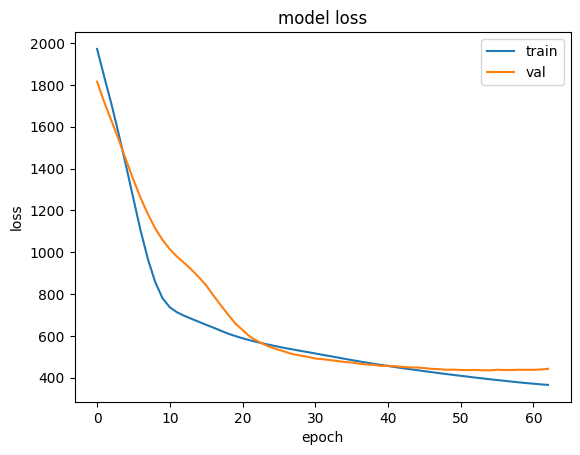

In [63]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [64]:
train_pred = vae_model.predict(train)[0]

461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step


In [65]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
# print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

# error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.23243431746959686
median error 0.21698100864887238
99Q: 0.5010259723663328


(array([ 25.,  43., 181., 336., 336., 451., 600., 593., 658., 904., 846.,
        688., 697., 666., 680., 658., 657., 648., 533., 598., 439., 337.,
        269., 241., 246., 357., 227., 262., 261., 264., 237., 152., 117.,
        140.,  66.,  51.,  41.,  34.,  26.,  22.,  21.,  20.,  31.,  23.,
         29.,  20.,  13.,   4.,   2.,   2.]),
 array([0.06048945, 0.07131131, 0.08213318, 0.09295505, 0.10377691,
        0.11459878, 0.12542064, 0.13624251, 0.14706437, 0.15788624,
        0.16870812, 0.17952998, 0.19035184, 0.20117371, 0.21199557,
        0.22281744, 0.23363931, 0.24446118, 0.25528303, 0.26610491,
        0.27692679, 0.28774863, 0.29857051, 0.30939236, 0.32021424,
        0.33103609, 0.34185797, 0.35267985, 0.3635017 , 0.37432358,
        0.38514543, 0.3959673 , 0.40678918, 0.41761103, 0.42843291,
        0.43925476, 0.45007664, 0.46089849, 0.47172037, 0.48254225,
        0.4933641 , 0.50418597, 0.51500785, 0.52582967, 0.53665155,
        0.54747343, 0.55829531, 0.56911719, 0.

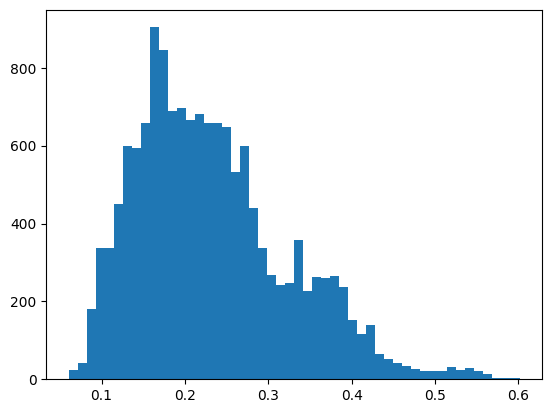

In [66]:
plt.hist(mae_vector, bins=50)

In [67]:
error_thresh = np.max(mae_vector) 
print(f'setting threshold on {error_thresh} ')

setting threshold on 0.6015827655792236 


In [68]:
#Actual ratio of anomalies 
ratio=1-np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.1665442796299016


In [69]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Avg error 0.5146372318267822
median error 0.5090737342834473


0.11925392862388016

(array([ 40.,  36.,  33., 100., 141.,  63.,  61.,  81., 225., 339., 190.,
        262., 339., 304., 387., 474., 208., 195., 301., 511., 422., 496.,
        343., 374., 186.,  97.,  46.,  24.,  33.,  16.,  22.,  13.,  11.,
          4.,   0.,   1.,   2.,  12.,  15.,  21.,  21.,  17.,  15.,  45.,
         59.,  78.,  69.,  49.,  14.,  14.]),
 array([0.26079443, 0.27482113, 0.2888478 , 0.30287451, 0.31690121,
        0.33092791, 0.34495458, 0.35898128, 0.37300798, 0.38703465,
        0.40106136, 0.41508806, 0.42911473, 0.44314143, 0.45716813,
        0.4711948 , 0.48522151, 0.49924821, 0.51327491, 0.52730161,
        0.54132831, 0.55535495, 0.56938165, 0.58340836, 0.59743506,
        0.61146176, 0.62548846, 0.6395151 , 0.6535418 , 0.6675685 ,
        0.68159521, 0.69562191, 0.70964861, 0.72367531, 0.73770195,
        0.75172865, 0.76575536, 0.77978206, 0.79380876, 0.80783546,
        0.8218621 , 0.8358888 , 0.8499155 , 0.86394221, 0.87796891,
        0.89199561, 0.90602231, 0.92004895, 0.

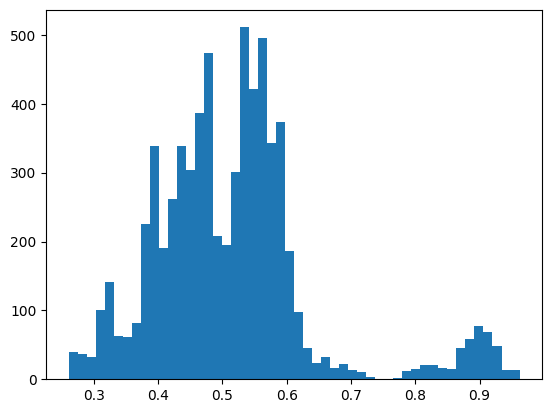

In [70]:
plt.hist(mae_vector_test, bins=50)

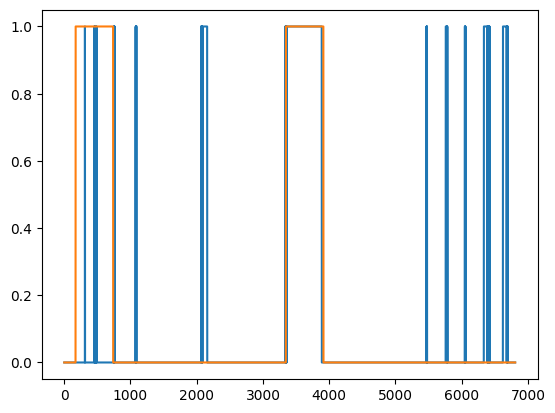

In [71]:
plt.plot(anomalies)
plt.plot(np.logical_not(labels_of_test))

In [72]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.90      0.95      0.93      5675
        True       0.67      0.48      0.56      1134

    accuracy                           0.87      6809
   macro avg       0.79      0.72      0.74      6809
weighted avg       0.86      0.87      0.87      6809



In [73]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_27084\3776165707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_27084\3776165707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

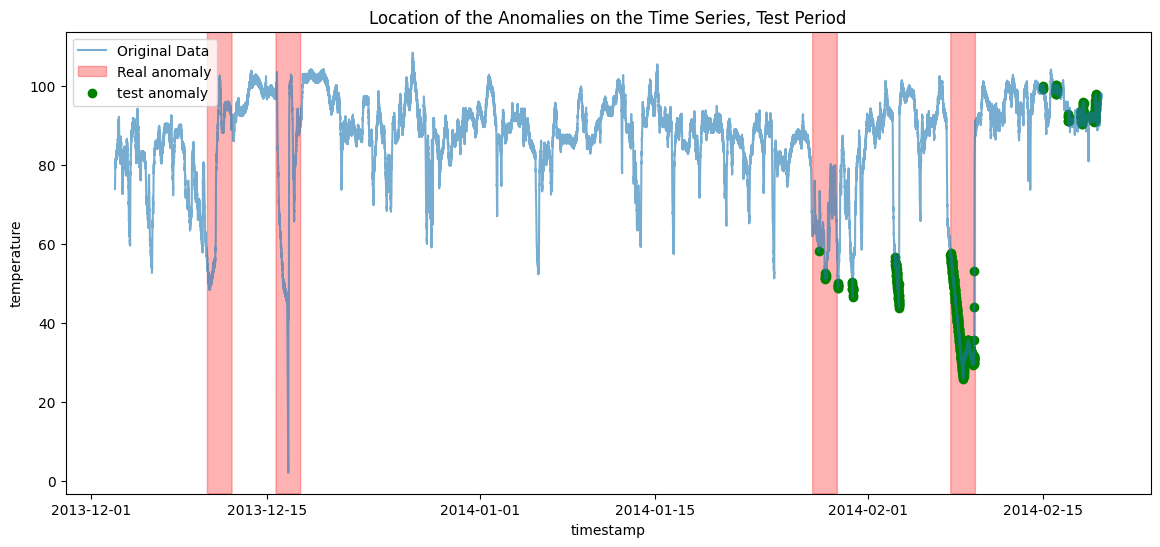

In [74]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==0, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=np.logical_not(data_w_ts['label']), color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")